## CACTI Radars Data Process: CSAPR2 HSRHI 90º-angle retrieval:

* For vertical motion (W) profile evolution, retrieve the ~90º angle of radial velocity from CSAPR2 HSRHI scans during the CACTI/RELAMPAGO campaign, and output them into a Time-Height dataset.

**Hungjui Yu 20220915**

***
***
## <font color='dodgerblue'>**Supplement Codes from Marqi:**</font>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from astropy.convolution import convolve, Gaussian2DKernel
import pyart
from csu_radartools import (csu_fhc, csu_liquid_ice_mass, csu_blended_rain, 
                            csu_dsd, csu_kdp, csu_misc, fundamentals)
import csu_radartools
import matplotlib.colors as colors
import difflib
import os
from datetime import datetime
import time



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/usr/local/anaconda3/lib/python3.8/site-packages/h5py/__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters


In [3]:
def two_panel_plot_csrhi(radar, sweep=0, var1='reflectivity', vmin1=0, vmax1=70,
                   cmap1='pyart_HomeyerRainbow', units1='dBZ', var2='differential_reflectivity',
                   vmin2=-5, vmax2=5, cmap2='RdYlBu_r', units2='ms-1', return_flag=True,
                   xlim=[-0.5,0.5], ylim=[0,20]):
    
    display = pyart.graph.RadarDisplay(radar)
    fig = plt.figure(figsize=(18,5))
    fig.patch.set_facecolor('xkcd:white')
    ax1 = fig.add_subplot(121)
    display.plot_rhi(var1, sweep=sweep, vmin=vmin1, vmax=vmax1, cmap=cmap1, 
                     colorbar_label=units1, mask_outside=True, title_flag=True)
    display.set_limits(xlim=xlim, ylim=ylim)
    ax2 = fig.add_subplot(122)
    display.plot_rhi(var2, sweep=sweep, vmin=vmin2, vmax=vmax2, cmap=cmap2, 
                     colorbar_label=units2, mask_outside=True, title_flag=True)
    display.set_limits(xlim=xlim, ylim=ylim)
    #plt.savefig('csapr2_20181214_0237_hsrhi30_regvel_10ints.png', dpi=400, bbox_inches='tight')
    
    if return_flag:
        return fig, ax1, ax2, display

/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
#read in pyart data
csrhi = '/rasmussen-scratch/mrocque/research/relampago/csapr2_qc/hsrhi/20181214/corcsapr2cfrhsrhiqcM1.b1.20181214.015600.csuqc.nc'

radar = pyart.io.read(csrhi)
radar.get_nyquist_vel(0) #get nyquist at the first sweep just to make sure nothing is weird

/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


16.492000579833984

In [8]:
time = (radar.time['data'])


/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
print (np.shape(time))

(2204,)


/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(<Figure size 1296x360 with 4 Axes>,
 <AxesSubplot:title={'center':'CSAPR2 0.0 Deg. 2018-12-14T01:56:00Z \nDZ (QCed)'}, xlabel='Distance from radar (km)', ylabel='Distance Above radar  (km)'>,
 <AxesSubplot:title={'center':'CSAPR2 0.0 Deg. 2018-12-14T01:56:00Z \nVR (QCed)'}, xlabel='Distance from radar (km)', ylabel='Distance Above radar  (km)'>,
 <pyart.graph.radardisplay.RadarDisplay at 0x7fa046f3f280>)

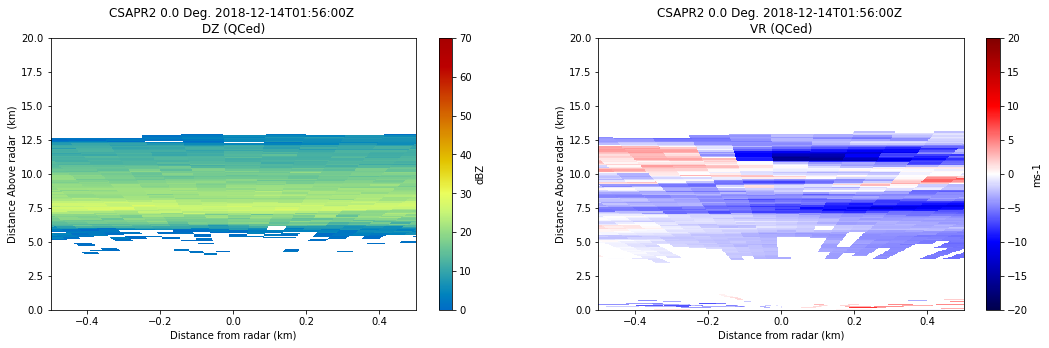

In [4]:
two_panel_plot_csrhi(radar, 0, var1='DZ_qc', vmin1=0, vmax1=70, cmap1='pyart_HomeyerRainbow', var2='VR_qc', vmin2=-20, 
               vmax2=20, cmap2='seismic')

In [5]:
#automatic dealias
velqc = pyart.correct.dealias_region_based(radar, vel_field='VR_qc', interval_splits=5)#, nyquist_vel=26.65)


field_dict = {'data':velqc['data'],'units':'ms-1', 'long_name':'velocity region-based5',
              'standard_name':'Velocity (QCed + reg5)', 
              '_FillValue':'-32768'}

radar.add_field('VR_qc2_reg5', field_dict, replace_existing=True)

/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
two_panel_plot_csrhi(radar, 0, var1='DZ_qc', vmin1=0, vmax1=70, cmap1='pyart_HomeyerRainbow', var2='VR_qc2_reg5', vmin2=-25, 
               vmax2=25, cmap2='seismic')

In [ ]:
#function to write out new file

#pyart.io.write_cfradial(outdir+new_file, radar)


In [6]:
elevs = radar.get_elevation(0)
azs = radar.get_azimuth(0)

/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print (elevs[175])

In [13]:
vel = radar.fields['VR_qc']['data']


#vel0 = radar0.fields['VR_qc']['data']

/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
print (radar.fields['VR_qc'])

{'_FillValue': -32768.0, 'long_name': 'Velocity (QCed)', 'units': 'm/s', 'standard_name': 'VR (QCed)', 'data': masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, 5.0356292724609375, ..., -3.8931126594543457, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True, False, ..., False,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=-32768.0,
  dtype=float32)}


/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
print (radar.time['data'][0:10])

[6960.       6960.082999 6960.165999 6960.249    6960.332    6960.414999
 6960.497999 6960.582    6960.664999 6960.747999]


/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
print (np.shape(vel))

(2204, 1100)


/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
vel0 = radar.get_field(0, 'VR_qc')[180,:]
vel1 = radar.get_field(0, 'VR_qc')[179,:]
vel2 = radar.get_field(0, 'VR_qc')[181,:]
vel3 = radar.get_field(0, 'VR_qc')[182,:]
vel4 = radar.get_field(0, 'VR_qc')[178,:]

/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
vels = radar.get_field(0, 'VR_qc')[:,:]

/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
print (radar.time['data'][358:360])

[6989.736999 6994.720999]


/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
t = 359
t1 = t + 360

print (radar.time['data'][t1]- radar.time['data'][t])

29.90400099999988


/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
print (np.shape(vels))

(359, 1100)


/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
vals = np.array(radar.get_gate_x_y_z(1))
print (type(vals))


z = (vals[2,180,:])/1000

<class 'numpy.ndarray'>


/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
x = (vals[0,180,:])
print (x)

[-0.000000e+00 -6.019965e+00 -1.203979e+01 ... -6.520383e+03 -6.526251e+03
 -6.532120e+03]


/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
print (np.shape(vals))

(3, 375, 1100)


/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print (vals[2,180,0:20])

/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


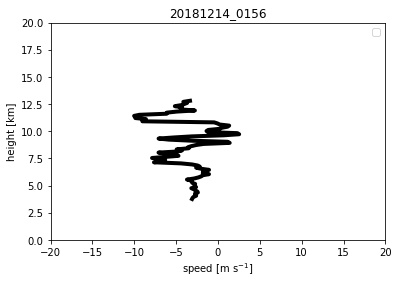

In [15]:
fig = plt.figure(figsize=(6,4))
fig.patch.set_facecolor('xkcd:white')

plt.plot(vel0, z, 'k', lw=4)#, label='90.40')

# for i in np.arange(0, len(vels), 1):
#     m = i + 177
#     plt.plot(vels[i], z, lw=1, label=elevs[m])
# plt.plot(vel0, z, 'k', lw=3, label='90.40')
# plt.plot(vel1, z, 'r', lw=1, label='89.85')
# plt.plot(vel2, z, 'b', lw=1, label='90.88')
# plt.plot(vel3, z, 'g', lw=1)
# plt.plot(vel4, z, 'y', lw=1)

plt.ylim(0, 20)
plt.xlim(-20, 20)

plt.legend()
plt.xlabel('speed [m s$^{-1}$]')
plt.ylabel('height [km]')

plt.title('20181214_0156')

plt.savefig('csapr2_test2.png', dpi=400, bbox_inches='tight')

In [ ]:
print (vel0[10:150])

In [ ]:
print (np.max(z))
print (np.shape(z))

In [ ]:
print (np.shape(x))

z = x[2,180,:]

In [ ]:
print (elevs[180])

In [ ]:
for i in np.arange(0, len(elevs), 1):
    if (elevs[i] < 91) & (elevs[i] > 89):
        

In [ ]:
print (len(elevs))